# Test UMAP embedding

This Notebook is testing if the UMAP embedding is artifically distorting our simulated gene expression data to appear closer to our original gene expression data

This notebook was created after the observation that the UMAP embedding of the original gene expression data and the simulated gene expression data appeared very similar.  But this similarity might be because we are using the UMAP embedding that was fit to the original data.

**Conclusion**
Based on the plots, we conclude that the umap embedding is not completely forcing the simulated data to look similar to the original data.  However, further experiments will need to be performed in order to better understand the role fo the umap embedding and if there is better way to represent the structure of the original and simulated data to confirm that they look similar.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import pandas as pd
import numpy as np
import random
from plotnine import (ggplot, 
                      geom_point,
                      labs,
                      aes, 
                      facet_wrap, 
                      scale_colour_manual,
                      guides, 
                      guide_legend, 
                      theme_bw, 
                      theme,  
                      element_text,
                      element_rect,
                      element_line,
                      element_blank,
                      ggsave)

from sklearn.decomposition import PCA
from keras.models import load_model
import umap

import warnings
warnings.filterwarnings(action='ignore')

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Function to generate simulated random noise
def simulate_noise(
    num_simulated_samples,
    num_genes
    
):
    '''
    Generate simulated noise.

    number_simulated_samples: int
        Number of samples to simulate

    Returns
    --------
    simulated_data_file: str
        File containing simulated gene expression data

    '''
    # Generate samples
    new_data = np.zeros([num_simulated_samples, num_genes])
    
    for j in range(num_genes):
        # Use mean and std for feature
        new_data[:, j] = np.random.normal(0,1, num_simulated_samples)

    new_data_df = pd.DataFrame(data=new_data)
    
    # Output
    return new_data_df

In [3]:
# User parameters
dataset_name = "Pseudomonas_analysis"
analysis_name = "analysis_0"

In [4]:
# Load data
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))    # base dir on repo
local_dir = "/home/alexandra/Documents"  

normalized_data_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "input",
    "train_set_normalized.pcl")

simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "simulated_data.txt.xz")

In [5]:
# Read data
normalized_data = pd.read_table(
    normalized_data_file,
    header=0,
    sep='\t',
    index_col=0).T

simulated_data = pd.read_table(
    simulated_data_file,
    header=0,
    sep='\t',
    index_col=0)

## Use simulated noise

In [6]:
# Generate simulated data
simulated_noise_data = simulate_noise(1000, 5549)

In [7]:
# Get and save model
model_original = umap.UMAP(random_state=randomState).fit(normalized_data)

input_data_UMAPencoded = model_original.transform(normalized_data)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=normalized_data.index,
                                         columns=['1','2'])

In [8]:
# UMAP embedding of simulated data
simulated_noise_data_UMAPencoded = model_original.transform(simulated_noise_data)
simulated_data_noise_UMAPencoded_df = pd.DataFrame(data=simulated_noise_data_UMAPencoded,
                                         index=simulated_noise_data.index,
                                         columns=['1','2'])

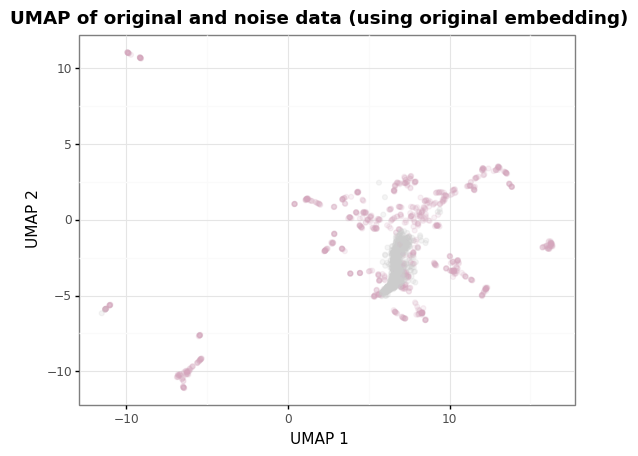

<ggplot: (-9223363290291523128)>


In [9]:
# Overlay original input vs simulated data

# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_noise_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_noise_UMAPencoded_df])

# Plot
g_input_sim = ggplot(combined_data_df[combined_data_df['dataset'] == 'original'], aes(x='1', y='2'))
g_input_sim += geom_point(color='#d5a6bd',
                          alpha=0.15)
g_input_sim += labs(x = "UMAP 1", 
                    y = "UMAP 2", 
                    title = "UMAP of original and noise data (using original embedding)")
g_input_sim += theme_bw()
g_input_sim += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    plot_title=element_text(weight='bold')
)
g_input_sim += geom_point(combined_data_df[combined_data_df['dataset'] == 'simulated'],
                          alpha=0.2, 
                          color='#cccccc')

print(g_input_sim)

## Use simulated data

In [10]:
# Get and save model
model_original = umap.UMAP(random_state=randomState).fit(normalized_data)

input_data_UMAPencoded = model_original.transform(normalized_data)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=normalized_data.index,
                                         columns=['1','2'])

In [11]:
# UMAP embedding of simulated data
model_simulated = umap.UMAP(random_state=randomState).fit(simulated_data)

simulated_data_UMAPencoded = model_simulated.transform(simulated_data)
simulated_data_UMAPencoded_df = pd.DataFrame(data=simulated_data_UMAPencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])

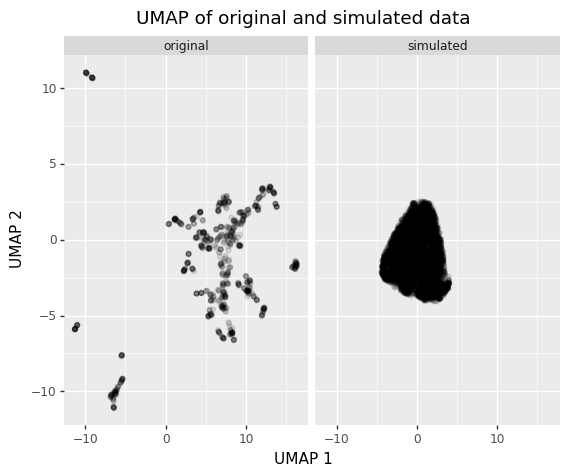

<ggplot: (-9223363290266239123)>

In [12]:
# Side by side original input vs simulated data

# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

# Plot
ggplot(combined_data_df, aes(x='1', y='2')) \
+ geom_point(alpha=0.1) \
+ facet_wrap('~dataset') \
+ labs(x = "UMAP 1", y = "UMAP 2", title = "UMAP of original and simulated data") \

## Use simulated data embedding

In [13]:
# UMAP embedding of simulated data
model_simulated = umap.UMAP(random_state=randomState).fit(simulated_data)

simulated_data_UMAPencoded = model_simulated.transform(simulated_data)
simulated_data_UMAPencoded_df = pd.DataFrame(data=simulated_data_UMAPencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])

In [14]:
# Get and save model
input_data_UMAPencoded = model_simulated.transform(normalized_data)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=normalized_data.index,
                                         columns=['1','2'])

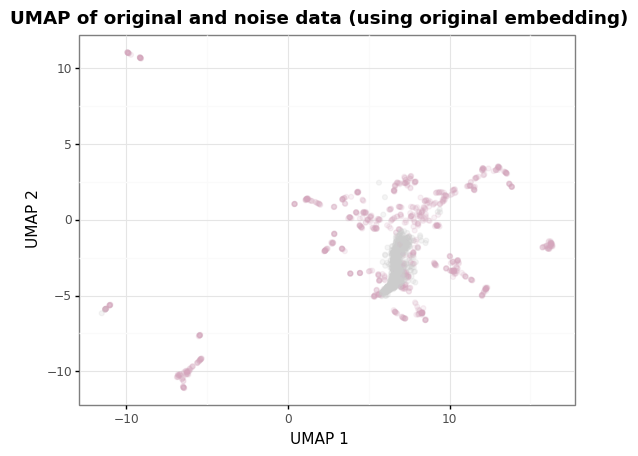

<ggplot: (-9223363290291523128)>


In [15]:
# Overlay original input vs simulated data

# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

# Plot
g_input_sim2 = ggplot(combined_data_df[combined_data_df['dataset'] == 'original'], aes(x='1', y='2'))
g_input_sim2 += geom_point(color='#d5a6bd',
                           alpha=0.2)
g_input_sim2 += labs(x = "UMAP 1", 
                     y = "UMAP 2", 
                     title = "UMAP of original and simulated data(using simulated embedding)")
g_input_sim2 += theme_bw()
g_input_sim2 += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    plot_title=element_text(weight='bold')
)
g_input_sim2 += geom_point(combined_data_df[combined_data_df['dataset'] == 'simulated'],
                           alpha=0.2, 
                           color='#cccccc')

print(g_input_sim)